#PROPUESTA DE REDES CONVOLUCIONALES GENUINAS

##1. Preparación de datos

In [ ]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8396003108980997892, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16470302883571017316
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprime en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/Convolutional-Regular/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (224, 224),                 
        batch_size  = 32,
        shuffle=True,
        color_mode='grayscale',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=True,
        color_mode='grayscale',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


##2. Red Convolucional 1

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 & MAX-POOLING3
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV5 & MAX-POOLING4
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV6 & MAX-POOLING5
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV7 & MAX-POOLING6
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO & RED DENSA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 66s 157ms/step - loss: 7.2197 - accuracy: 0.7337 - val_loss: 8.6620 - val_accuracy: 0.3617
Epoch 2/60
412/412 [==============================] - 64s 156ms/step - loss: 6.3156 - accuracy: 0.8403 - val_loss: 6.0022 - val_accuracy: 0.8304
Epoch 3/60
412/412 [==============================] - 64s 156ms/step - loss: 5.5715 - accuracy: 0.8740 - val_loss: 5.4756 - val_accuracy: 0.7840
Epoch 4/60
412/412 [==============================] - 64s 156ms/step - loss: 4.9055 - accuracy: 0.8959 - val_loss: 4.9097 - val_accuracy: 0.7882
Epoch 5/60
412/412 [==============================] - 64s 156ms/step - loss: 4.3101 - accuracy: 0.9111 - val_loss: 4.4834 - val_accuracy: 0.7855
Epoch 6/60
412/412 [==============================] - 64s 156ms/step - loss: 3.7728 - accuracy: 0.9284 - val_loss: 3.8138 - val_accuracy: 0.8258
Epoch 7/60
412/412 [==============================] - 64s 156ms/step - loss: 3.3370 - accuracy: 0.9306 - val_loss: 3.4758 - val_ac

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'Convolutional-Regularmodel.h5')
history = np.load(base_dir + 'Convolutional-Regularhistory.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

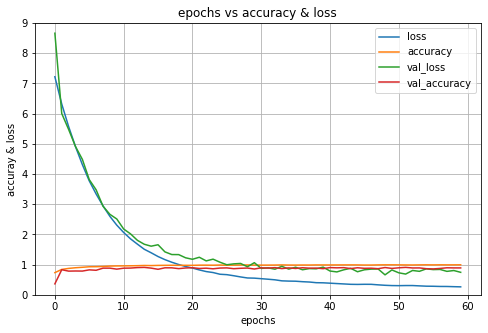

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
plt.ylim(0,9)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 6s 55ms/step - loss: 0.7445 - accuracy: 0.8902


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

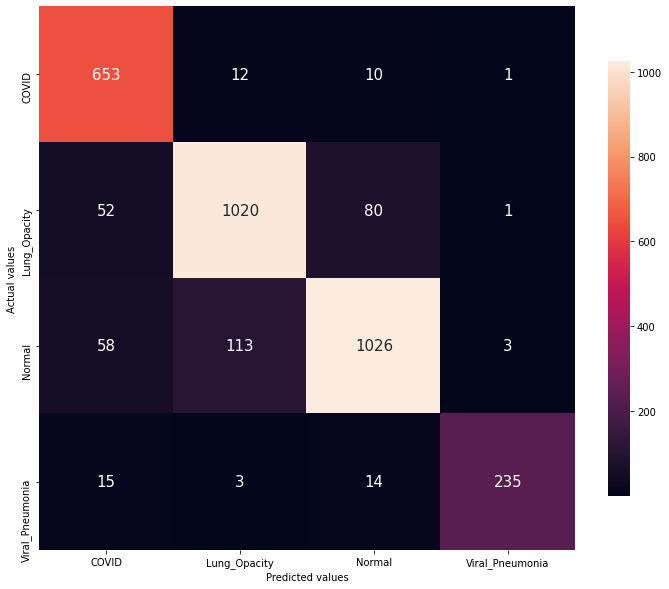

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.84      0.97      0.90       676
   Lung_Opacity       0.89      0.88      0.89      1153
         Normal       0.91      0.85      0.88      1200
Viral_Pneumonia       0.98      0.88      0.93       267

       accuracy                           0.89      3296
      macro avg       0.90      0.90      0.90      3296
   weighted avg       0.89      0.89      0.89      3296



##3. Red Convolucional 2: Aumento de filtros en las primeras capas 

In [ ]:
## DEFINICIÓN DE LA TOPOLOGÍA DE LA RED NEURONAL
## =============================================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 & CONV5 & CONV 6 MAX-POOLING3
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV7 & CONV8 & CONV9 MAX-POOLING4
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV10 & MAX-POOLING5
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV11 & MAX-POOLING6
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO & RED DENSA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [ ]:
## COMPILACIÓN DEL MODELO
## ====================================================================
model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## ===================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'more_firstLayers.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'more_firstLayers.npy', history.history)

Epoch 1/60
412/412 [==============================] - 85s 205ms/step - loss: 5.7947 - accuracy: 0.7207 - val_loss: 3.7129 - val_accuracy: 0.4287
Epoch 2/60
412/412 [==============================] - 82s 199ms/step - loss: 1.5460 - accuracy: 0.7855 - val_loss: 1.1632 - val_accuracy: 0.7734
Epoch 3/60
412/412 [==============================] - 82s 199ms/step - loss: 1.0206 - accuracy: 0.7950 - val_loss: 1.4043 - val_accuracy: 0.5473
Epoch 4/60
412/412 [==============================] - 82s 199ms/step - loss: 0.9144 - accuracy: 0.8015 - val_loss: 1.2761 - val_accuracy: 0.6019
Epoch 5/60
412/412 [==============================] - 82s 199ms/step - loss: 0.8536 - accuracy: 0.8076 - val_loss: 1.1410 - val_accuracy: 0.7090
Epoch 6/60
412/412 [==============================] - 82s 198ms/step - loss: 0.8056 - accuracy: 0.8218 - val_loss: 1.4339 - val_accuracy: 0.5834
Epoch 7/60
412/412 [==============================] - 81s 197ms/step - loss: 0.7933 - accuracy: 0.8214 - val_loss: 0.8868 - val_ac

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'more_firstLayers.h5')
history = np.load(base_dir + 'more_firstLayers.npy', allow_pickle='TRUE').item()

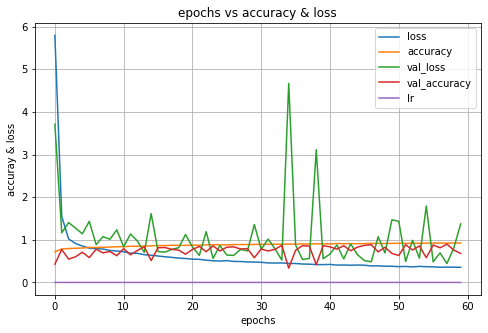

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 194s 2s/step - loss: 1.3731 - accuracy: 0.6805


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

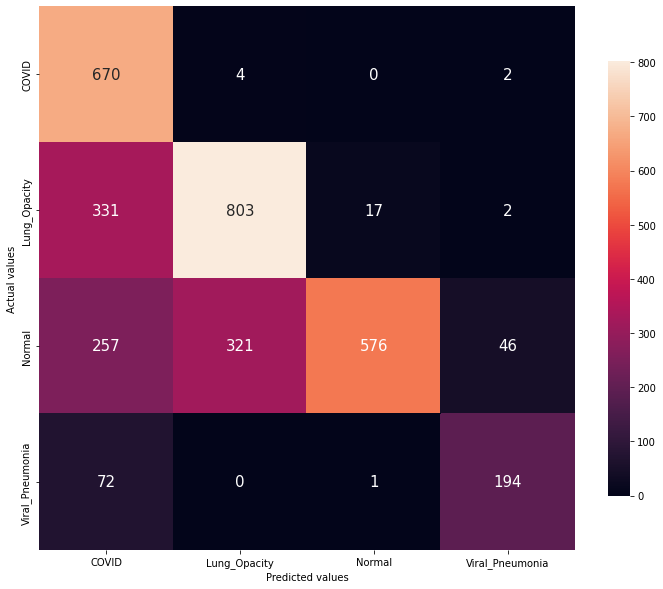

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.50      0.99      0.67       676
   Lung_Opacity       0.71      0.70      0.70      1153
         Normal       0.97      0.48      0.64      1200
Viral_Pneumonia       0.80      0.73      0.76       267

       accuracy                           0.68      3296
      macro avg       0.75      0.72      0.69      3296
   weighted avg       0.77      0.68      0.68      3296



##4. Red Convolucional 3: Implementación de weight class

In [ ]:
## NÚMERO DE IMÁGENES POR CATEGORÍA (train)
## =============================================================================

from collections import Counter

counter = Counter(train_generator.classes)
counter

Counter({0: 2702, 1: 4608, 2: 4800, 3: 1068})

In [ ]:
## NÚMERO MÁXIMO DE IMÁGENES
## =============================================================================

max = max(counter.values())
max

In [ ]:
## CATEGORIAS
## =============================================================================

train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

In [ ]:
## NÚMERO DE IMÁGENES POR CATEGORÍA (test)
## =============================================================================

counter = Counter(test_generator.classes)
counter

Counter({0: 676, 1: 1153, 2: 1200, 3: 267})

In [ ]:
## NÚMERO MÁXIMO DE IMÁGENES
## =============================================================================

max = max(counter.values())
max

In [ ]:
## DICCIONARIO CON LOS COEFICIENTES 
## =============================================================================

class_weight = {}

for i in range(4):
  class_weight[i] = max / counter[i]

class_weight

{0: 1.7751479289940828, 1: 1.0407632263660018, 2: 1.0, 3: 4.49438202247191}

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 & MAX-POOLING3
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV5 & MAX-POOLING4
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV6 & MAX-POOLING5
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV7 & MAX-POOLING6
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO & RED DENSA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'class_weight.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  class_weight=class_weight,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'class_weight.npy', history.history)

Epoch 1/60
412/412 [==============================] - 93s 154ms/step - loss: 4.7706 - accuracy: 0.7319 - val_loss: 3.0631 - val_accuracy: 0.4648
Epoch 2/60
412/412 [==============================] - 61s 149ms/step - loss: 1.7255 - accuracy: 0.7911 - val_loss: 1.9548 - val_accuracy: 0.5276
Epoch 3/60
412/412 [==============================] - 61s 149ms/step - loss: 1.3409 - accuracy: 0.7991 - val_loss: 1.6844 - val_accuracy: 0.7087
Epoch 4/60
412/412 [==============================] - 62s 149ms/step - loss: 1.2421 - accuracy: 0.8101 - val_loss: 2.0182 - val_accuracy: 0.5604
Epoch 5/60
412/412 [==============================] - 61s 149ms/step - loss: 1.2161 - accuracy: 0.8201 - val_loss: 1.5918 - val_accuracy: 0.5934
Epoch 6/60
412/412 [==============================] - 61s 149ms/step - loss: 1.1980 - accuracy: 0.8178 - val_loss: 1.1011 - val_accuracy: 0.7958
Epoch 7/60
412/412 [==============================] - 61s 148ms/step - loss: 1.1392 - accuracy: 0.8250 - val_loss: 1.6759 - val_ac

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'class_weight.h5')
history = np.load(base_dir + 'class_weight.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

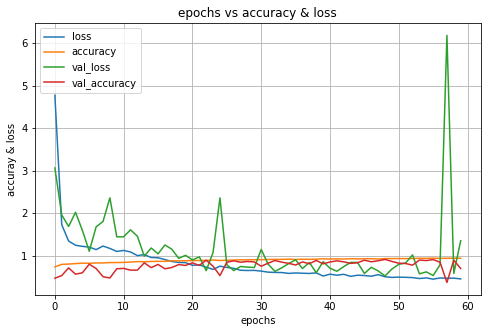

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 5s 51ms/step - loss: 1.3491 - accuracy: 0.6936


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


array([0, 0, 0, ..., 3, 3, 0])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

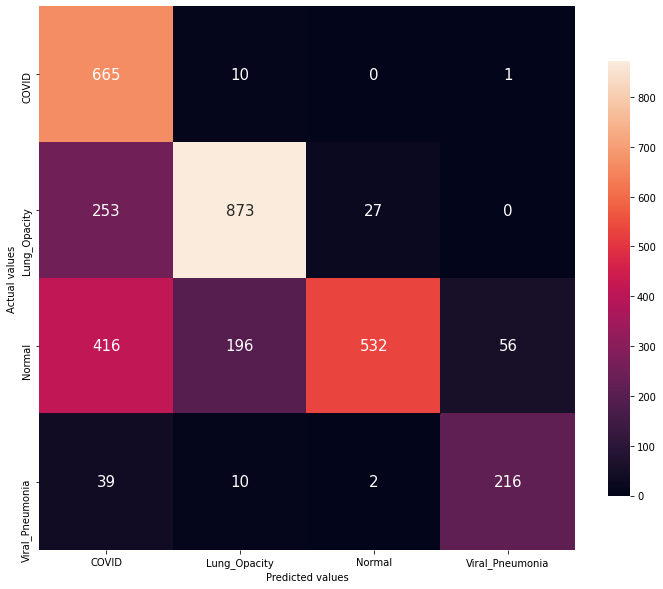

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualizacion)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.48      0.98      0.65       676
   Lung_Opacity       0.80      0.76      0.78      1153
         Normal       0.95      0.44      0.60      1200
Viral_Pneumonia       0.79      0.81      0.80       267

       accuracy                           0.69      3296
      macro avg       0.76      0.75      0.71      3296
   weighted avg       0.79      0.69      0.69      3296



##5. Red Convolucional 4: Aumento de filtros convolucionales

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

DefaultConv2D = partial(Conv2D,
                         kernel_size=3, 
                         activation='relu',
                         padding='same',
                         strides=1,
                         kernel_regularizer =L2(0.01))

model = Sequential([
    
    # CONV1 Y MAX-POOLING1                           
    DefaultConv2D(filters=32, input_shape=[224, 224, 1]),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV2 & CONV3 Y MAX-POOLING2
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV4 & CONV5 Y MAX-POOLING3
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV6 & CONV7 Y MAX-POOLING4
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
   
    # CONV8 & CONV9 Y MAX-POOLING5
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),

    # CONV10 & CONV11 Y MAX-POOLING6
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPooling2D(pool_size=3),
    BatchNormalization(),

    # APLANADO Y RED CLÁSICA
    Flatten(),
    Dropout(0.4),
    Dense(units=32, activation='relu'),
    Dense(units=4, activation='softmax'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss='categorical_crossentropy', 
               optimizer= 'adam',
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'model_MoreConv.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=60,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'history_MoreConv.npy', history.history)

Epoch 1/60
412/412 [==============================] - 109s 186ms/step - loss: 14.0511 - accuracy: 0.7395 - val_loss: 15.4262 - val_accuracy: 0.3623
Epoch 2/60
412/412 [==============================] - 75s 181ms/step - loss: 12.4723 - accuracy: 0.8365 - val_loss: 11.8642 - val_accuracy: 0.7897
Epoch 3/60
412/412 [==============================] - 75s 181ms/step - loss: 10.9374 - accuracy: 0.8680 - val_loss: 10.3416 - val_accuracy: 0.8356
Epoch 4/60
412/412 [==============================] - 75s 181ms/step - loss: 9.4723 - accuracy: 0.8903 - val_loss: 9.3323 - val_accuracy: 0.7418
Epoch 5/60
412/412 [==============================] - 75s 181ms/step - loss: 8.1260 - accuracy: 0.9022 - val_loss: 7.7217 - val_accuracy: 0.8225
Epoch 6/60
412/412 [==============================] - 75s 181ms/step - loss: 6.9115 - accuracy: 0.9148 - val_loss: 6.4900 - val_accuracy: 0.8714
Epoch 7/60
412/412 [==============================] - 75s 181ms/step - loss: 5.8736 - accuracy: 0.9185 - val_loss: 6.1195 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'Convolutional-Regularmodel_MoreConv.h5')
history = np.load(base_dir + 'Convolutional-Regularhistory_MoreConv.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

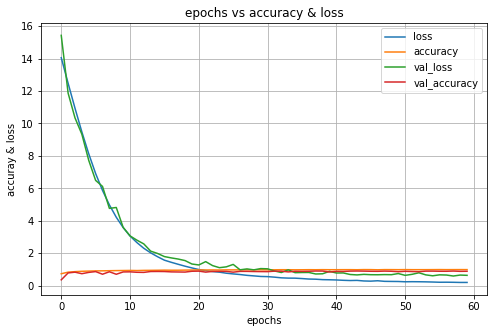

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO 
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 7s 63ms/step - loss: 0.6407 - accuracy: 0.8911


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CAREGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

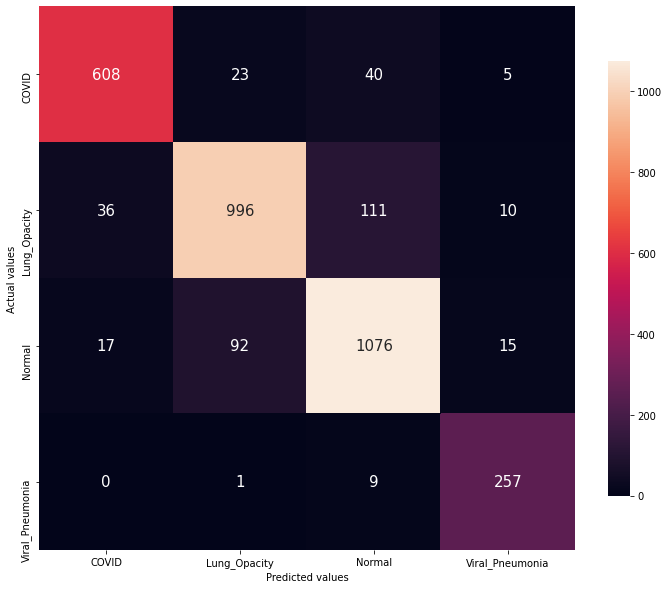

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## ======================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.92      0.90      0.91       676
   Lung_Opacity       0.90      0.86      0.88      1153
         Normal       0.87      0.90      0.88      1200
Viral_Pneumonia       0.90      0.96      0.93       267

       accuracy                           0.89      3296
      macro avg       0.90      0.91      0.90      3296
   weighted avg       0.89      0.89      0.89      3296

